In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
import pickle
import gc
import seaborn
from matplotlib import pyplot as plt
from PIL import Image
import os

In [2]:
from input import DataInputTest
from model import Model

In [3]:
config = {
    'hidden_units': 128,
    'num_blocks': 1,
    'num_heads': 8,
    'dropout': 0.0,
    'regulation_rate': 0.00005,

    'itemid_embedding_size': 64,
    'cateid_embedding_size': 64,
    'input_image_emb_size': 64,
    'input_text_emb_size': 300,

    'concat_time_emb': True,

    # Training parameters
    'from_scratch': True,
    'model_dir': 'evaluate',
    'optimizer': 'sgd',
    'learning_rate': 1.0,
    'max_gradient_norm': 5.0,

    'train_batch_size': 32,
    'test_batch_size': 128,
    'max_epochs': 10,

    'display_freq': 100,
    'eval_freq': 10000,
}

In [4]:
with open('dataset.pkl', 'rb') as f:
    pickle.load(f)
    test_set = pickle.load(f)
    cate_list = pickle.load(f)
    user_count, item_count, cate_count = pickle.load(f)
    img_list, images = pickle.load(f)
    _, texts = pickle.load(f)

In [5]:
config['user_count'] = user_count
config['item_count'] = item_count
config['cate_count'] = cate_count

In [6]:
def create_model(sess, config, cate_list):
    model = Model(config, cate_list)

    ckpt = tf.train.get_checkpoint_state('multimodal_attention_relu_dropout')
    model.restore(sess, ckpt.model_checkpoint_path)
    return model

In [7]:
# CPUで実行
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [8]:
batch_size = config['test_batch_size']
print('Batch size: %d, %d batches' % (batch_size, int(len(test_set) / batch_size+0.5)))

Batch size: 128, 1503 batches


In [9]:
datt, eatt, mm_sel, all_hist_i, all_hist_r = [], [], [], [], []

i_img_att, i_text_att, i_all = 0, 0, 0

tf.reset_default_graph()
print('Starting Test...')

# Initiate TF session
with tf.Session() as sess:
    model = create_model(sess, config, cate_list)

    for i, uij in DataInputTest(test_set, batch_size, images, img_list, texts):
        # 各インスタンスのシーケンスの長さのリスト
        sl = uij[5]
        hist_i = uij[3]
        hist_r = uij[8]
        _, _, datt_1, eatt_1, datt_2, eatt_2, mm_sel_1, _ = model.test(sess, uij)

        # b_datt = np.concatenate((np.expand_dims(datt_1, 1), np.expand_dims(datt_2, 1)), axis=1)
        # b_eatt = np.concatenate((np.expand_dims(eatt_1, 1), np.expand_dims(eatt_2, 1)), axis=1)

        for j in range(mm_sel_1.shape[0]):
            # datt.append(b_datt[j])
            # eatt.append(b_eatt[j])
            mm_sel.append(mm_sel_1[j, :sl[j]])
            all_hist_i.append(hist_i[j, :sl[j]])
            all_hist_r.append(hist_r[j, :sl[j]])

        print('Processed batch %d' % i)

print('Finished', flush=True)

h 530
Processed batch 531
Processed batch 532
Processed batch 533
Processed batch 534
Processed batch 535
Processed batch 536
Processed batch 537
Processed batch 538
Processed batch 539
Processed batch 540
Processed batch 541
Processed batch 542
Processed batch 543
Processed batch 544
Processed batch 545
Processed batch 546
Processed batch 547
Processed batch 548
Processed batch 549
Processed batch 550
Processed batch 551
Processed batch 552
Processed batch 553
Processed batch 554
Processed batch 555
Processed batch 556
Processed batch 557
Processed batch 558
Processed batch 559
Processed batch 560
Processed batch 561
Processed batch 562
Processed batch 563
Processed batch 564
Processed batch 565
Processed batch 566
Processed batch 567
Processed batch 568
Processed batch 569
Processed batch 570
Processed batch 571
Processed batch 572
Processed batch 573
Processed batch 574
Processed batch 575
Processed batch 576
Processed batch 577
Processed batch 578
Processed batch 579
Processed batc

In [10]:
propotion = np.zeros((len(mm_sel), max([len(i) for i in mm_sel]), 2), dtype=np.float32)

In [11]:
for i in range(len(mm_sel)):
    propotion[i, :mm_sel[i].shape[0]] = mm_sel[i]

In [12]:
propotion.sum(axis=(0, 1))

array([ 121878.32, 1376933.2 ], dtype=float32)

In [13]:
i_img_att, i_text_att = 0, 0
propotion = np.zeros(len(mm_sel))
for i in range(len(mm_sel)):
    summed = mm_sel[i].sum(axis=0)
    i_img_att += summed[0]
    i_text_att += summed[1]
    propotion[i] = summed[0] / (summed[0] + summed[1] + 0.001)
print(i_img_att, i_text_att, i_img_att/(i_img_att+i_text_att))

122053.14443011455 1374731.861070156 0.08154353763673675


(array([3.8748e+04, 1.3364e+04, 9.4820e+03, 8.0900e+03, 7.8980e+03,
        8.4850e+03, 8.6450e+03, 9.3980e+03, 1.0472e+04, 7.9000e+03,
        1.1581e+04, 6.7460e+03, 1.2564e+04, 6.7870e+03, 5.1710e+03,
        3.8070e+03, 3.6000e+03, 2.8380e+03, 2.1700e+03, 1.7030e+03,
        2.6890e+03, 1.4740e+03, 1.0800e+03, 8.6300e+02, 1.0630e+03,
        2.3580e+03, 6.2900e+02, 4.2900e+02, 3.5300e+02, 2.9800e+02,
        4.4300e+02, 1.8400e+02, 1.3900e+02, 1.6100e+02, 8.9000e+01,
        9.2000e+01, 7.7000e+01, 2.7300e+02, 5.8000e+01, 4.3000e+01,
        3.8000e+01, 2.4000e+01, 1.8000e+01, 1.3000e+01, 6.0000e+00,
        6.0000e+00, 5.0000e+00, 3.0000e+00, 2.0000e+00, 4.4000e+01]),
 array([5.51808824e-09, 9.99833902e-03, 1.99966725e-02, 2.99950060e-02,
        3.99933395e-02, 4.99916730e-02, 5.99900065e-02, 6.99883400e-02,
        7.99866735e-02, 8.99850070e-02, 9.99833405e-02, 1.09981674e-01,
        1.19980008e-01, 1.29978341e-01, 1.39976675e-01, 1.49975008e-01,
        1.59973342e-01, 1.6997

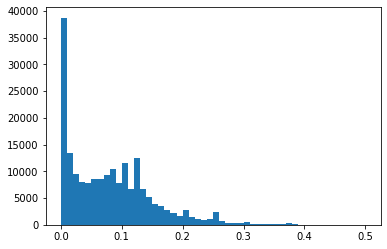

In [14]:
plt.hist(propotion, 50)

In [15]:
import pickle
with open('../raw_data/remap.pkl', 'rb') as f:
  pickle.load(f)
  pickle.load(f)
  pickle.load(f)
  asin_key, cate_key, revi_key = pickle.load(f)
  img_list, img_key = pickle.load(f)
  text_list, text_key = pickle.load(f)

In [16]:
with open('../raw_data/meta.pkl', 'rb') as f:
    meta = pickle.load(f)
    meta = meta.sort_values('asin')

In [17]:
def get_title(hist_i):
    keys = np.array(meta.title, dtype=object)
    return keys[hist_i]

In [18]:
def get_image(hist_i):
    keys = np.array(img_key)[img_list[hist_i]]
    return [Image.open('../raw_data/images/' + key) for key in keys]

In [19]:
def get_review_text(hist_r):
    keys = np.array(text_key, dtype=object)
    return keys[hist_r]

In [20]:
median = np.where(propotion == np.median(propotion))[0]
median = median[int(median.shape[0] / 2)]

In [21]:
mm_sel[median]

array([[2.6862121e-01, 7.3137885e-01],
       [1.8380714e-06, 9.9999821e-01],
       [5.7118428e-05, 9.9994290e-01],
       [1.7830608e-02, 9.8216945e-01]], dtype=float32)

<AxesSubplot:>

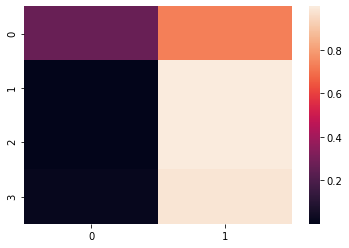

In [22]:
seaborn.heatmap(mm_sel[median])

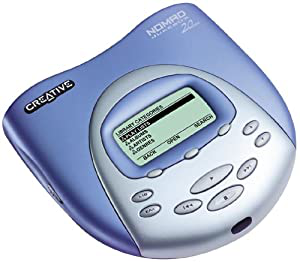

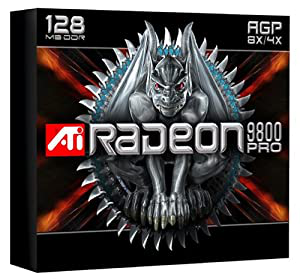

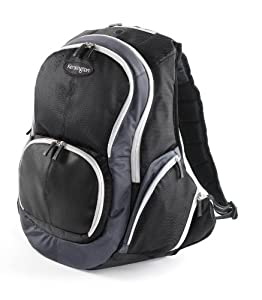

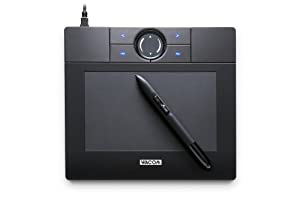

In [23]:
for image in get_image(all_hist_i[median]):
    display(image)

In [24]:
print(*get_title(all_hist_i[median]), sep='\n')

Creative Labs 20 GB Nomad Jukebox
ATI Technologies 100-435002 Radeon 9800 Pro 128MB
Kensington 62232 SaddleBag Sport Backpack for 15- to 17-Inch Notebooks
Bamboo (Small) Pen Tablet with Pen Only


In [25]:
print(*get_review_text(all_hist_r[median]), sep='\n')

This was an easy choice for me, because it's currently still the only 20GB player on the market. If, like me, you have lots and lots of music, size matters. As big as this is, I expect I will upgrade in 2-3 years when they have 50-60GB models.If you really like music, this unit will reorganize your life. You can carry around all (well, an awful lot, anyway) of your music, organize it into as many different playlists as you want, and play it pretty much anywhere. Of course, there are also some annoying problems, but don't let that stop you from getting an amazing device like this.The best parts: (1) Sound quality. For all but audiophile equipment, the limitation on sound quality will either be the MP3 file (if it's a low-grade one) or the equipment you play it through (mass-market stereos and headphones, etc). If you hook this up to an expensive audiophile system, you will hear its limitations, but it plays compressed sound files anyway, so that's no surprise. (2) It goes everywhere and

In [26]:
most_high_prop = np.argmax(propotion)

In [27]:
mm_sel[most_high_prop]

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]], dtype=float32)

<AxesSubplot:>

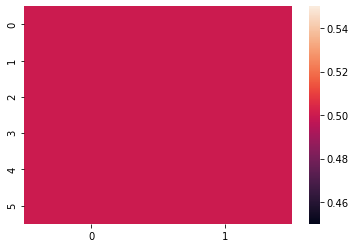

In [28]:
seaborn.heatmap(mm_sel[most_high_prop])

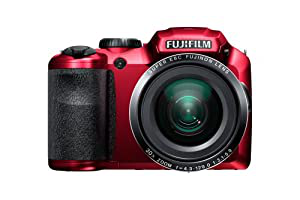

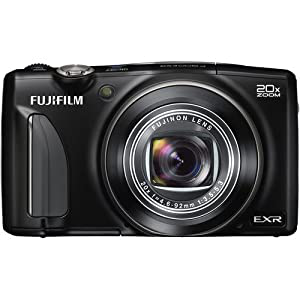

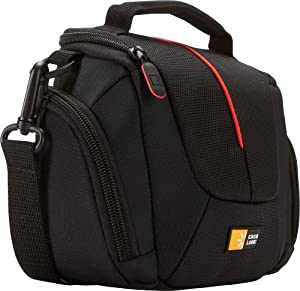

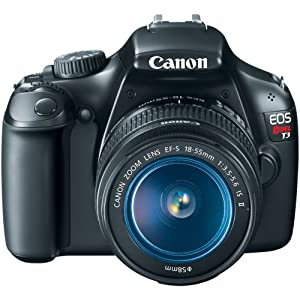

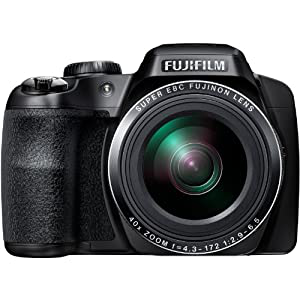

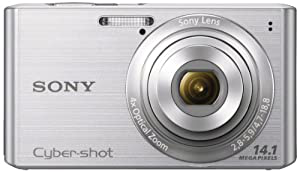

In [29]:
for image in get_image(all_hist_i[most_high_prop]):
    display(image)

In [30]:
print(*get_title(all_hist_i[most_high_prop]), sep='\n')

Fujifilm FinePix S6800 16MP Digital Camera with 3-Inch LCD (Red)
Fujifilm FinePix F900EXR 16MP Digital Camera with 3-Inch LCD (Black)
Case Logic DCB-304 Compact System/Hybrid Camera Case (Black)
Canon EOS Rebel T3 12.2 MP CMOS Digital SLR with 18-55mm IS II Lens and EOS HD Movie Mode (Black)
Fujifilm FinePix S8200 16.2MP Digital Camera with 3-Inch LCD (Black)
Sony Cyber-shot DSCW610 14.1 MP Digital Camera with 4x Optical Zoom and 2.7-Inch LCD (Silver) (2012 Model)


In [31]:
print(*get_review_text(all_hist_r[most_high_prop]), sep='\n')

I really wanted this camera to work out, but after taking several test shots in different lighting situations indoors & outdoors, I returned it. I want a camera with long zoom, but I still want to use the auto settings. My main complaint is this camera always chose higher iso resulting in noisy/grainy pictures. Indoors (with window shades open & sunlight coming in) the pictures were very noisy, not even acceptable. Outdoors the pictures were much better with little noise but still choosing a higher iso resulting in slightly more noise than my Samsung Galaxy Note II. I'll have to do without the long zoom, but for now I'll continue using my phone.
I am not a professional ... just a mom shooting everyday pics of my kids. I like to get snapshots at family & special events. I have no interest in post processing photos except to maybe use the auto adjust in Windows Photo Gallery or on the print kiosk at Walmart or Walgreen's or wherever I'm printing. And there are times when I do want to cro